In [1]:
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import torch

from sbi.analysis import pairplot, plot_summary, conditional_pairplot
from sbi.inference import SNPE
from sbi.utils import BoxUniform

In [2]:
def load_latest_csv(pattern="ice_fishing_simulations_*.csv") -> pd.DataFrame:
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files match pattern: {pattern}")
    # pick lexicographically last = latest dd.mm.yyyy if names consistent
    latest = files[-1]
    print(f"Loading {latest}")
    return pd.read_csv(latest)

def reparam_weights_to_stick_breaking(df: pd.DataFrame) -> np.ndarray:
    """Return [v1, v2] from weights. Handles edge cases numerically."""
    w1 = df["spot_selection_w_social"].to_numpy()
    w2 = df["spot_selection_w_success"].to_numpy()
    denom = 1.0 - w1
    eps = 1e-8
    v1 = w1
    v2 = np.divide(w2, np.maximum(denom, eps))
    v2 = np.clip(v2, 0.0, 1.0)
    
    df["spot_selection_w_social"].to_numpy()
    df["spot_selection_w_success"].to_numpy()

In [3]:
df = load_latest_csv()
df.head()

Loading ice_fishing_simulations_26.09.2025.csv


,RunId,iteration,Step,grid_size,number_of_agents,simulation_length_minutes,sample_from_prior,catch,travel_distance,successful_locations,failure_locations,sampling_time_successful_spot,sampling_time_failure_spot,spot_selection_w_social,spot_selection_w_success,spot_selection_w_failure,spot_selection_tau,spot_leaving_time_weight,fish_abundance
0,62,0,1080,90,6,180,{'spot_selection_w_social': 0.2131470486929857...,95.833333,1553.913909,9.666667,24.166667,37.750000,22.444444,0.213147,0.105750,0.681103,0.078217,0.431651,2.168216
1,1,0,1080,90,6,180,{'spot_selection_w_social': 0.3034703300110496...,1.666667,1886.476619,1.333333,34.000000,2.111111,31.888889,0.303470,0.281320,0.415209,0.330228,0.216671,3.408613
2,55,0,1080,90,6,180,{'spot_selection_w_social': 0.1221488613203611...,22.166667,1773.229122,6.833333,27.333333,13.000000,25.138889,0.122149,0.170264,0.707587,0.610649,0.119478,2.125678
3,3,0,1080,90,6,180,{'spot_selection_w_social': 0.1373567482573655...,2.833333,1814.938343,1.000000,37.833333,2.138889,35.555556,0.137357,0.544971,0.317672,0.750463,0.575780,3.511304
4,63,0,1080,90,6,180,{'spot_selection_w_social': 0.0139721168688558...,29.833333,1696.433759,8.166667,30.666667,17.861111,28.250000,0.013972,0.690773,0.295255,0.925804,0.394322,2.139225


In [4]:
PARAM_COLS = [
    "spot_selection_w_social",
    "spot_selection_w_success",
    # "spot_selection_w_failure",
    "spot_selection_tau",
    "spot_leaving_time_weight",
    "fish_abundance",
]

PARAM_LABS = [
    r"$a_{social}$", 
    r"$a_{success}$", 
    # r"$a_{failure}$", 
    r"$\tau$",
    r"$w_{time}$",
    r"$b$"
]

df["travel_distance"] /= 1000
df["n_spots"] = df["successful_locations"] + df["failure_locations"]
df["success_spots"] = df["successful_locations"] / df["n_spots"]
df["sampling_time"] = (df["sampling_time_successful_spot"] / df["successful_locations"] + 
                       df["sampling_time_failure_spot"] / df["failure_locations"]) / 2

SUMMARY_COLS = [
    "catch",
    "travel_distance",
    "n_spots",
    "success_spots",
#    "sampling_time"
#     "travel_distance",
#     "successful_locations",
#     "failure_locations",
    "sampling_time_successful_spot",
    "sampling_time_failure_spot",
]


In [14]:
theta_np = df[PARAM_COLS].to_numpy()
X_np = df[SUMMARY_COLS].to_numpy()
theta = torch.as_tensor(theta_np, dtype=torch.float32)
X = torch.as_tensor(X_np, dtype=torch.float32)
# x_obs = torch.as_tensor([3, 1.2, 33.5, 0.15, 3.5], dtype=torch.float32)
# x_obs = torch.as_tensor([3, 1.2, 33.5, 0.15, 3.5], dtype=torch.float32)
x_obs = torch.as_tensor([15, 1.2, 36, 0.2, 14 * 7.2, 1.5 * 28.8], dtype=torch.float32)

In [6]:
SUMMARY_COLS

['catch',
 'travel_distance',
 'n_spots',
 'success_spots',
 'sampling_time_successful_spot',
 'sampling_time_failure_spot']

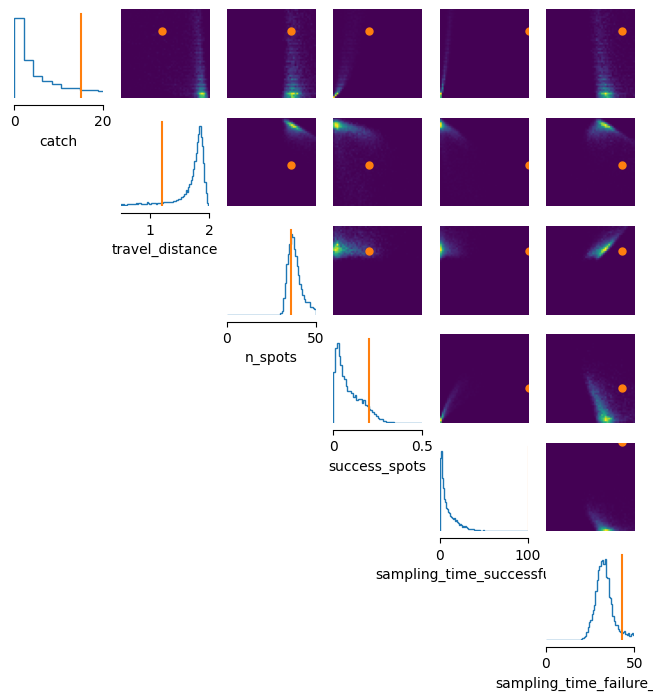

In [16]:
_ = pairplot(
    samples=X,
    points=x_obs[None, :],  # `points` needs a batch dimension.
    limits=[[0, 20], [0.5, 2], [0, 50], [0, 0.5], [0, 100], [0, 50]],
    labels=SUMMARY_COLS,
    figsize=(8, 8),
)

In [9]:
inference = SNPE()
density_estimator = inference.append_simulations(theta, X).train()

 Neural network successfully converged after 224 epochs.

For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/valery/SIOI/IceFishingABM-MESA/sbi_inference/sbi-logs/NPE_C/2025-09-27T16_29_53.101588' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


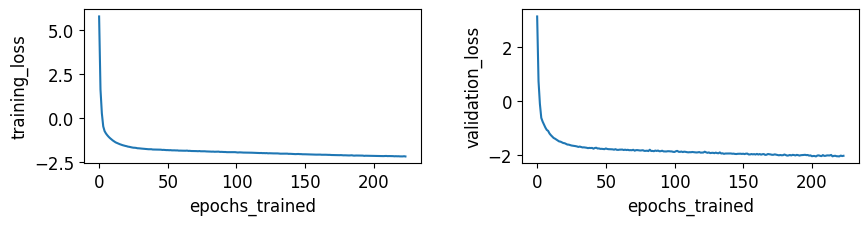

In [10]:
_ = plot_summary(
    inference,
    tags=["training_loss", "validation_loss"],
    figsize=(10, 2),
)

In [17]:
posterior = inference.build_posterior()
# cond_posterior = posterior.set_default_x(x_obs)
# .condition(torch.as_tensor([[float("nan"), float("nan"), float("nan"), float("nan"), 3.5]]))

In [18]:
SUMMARY_COLS

['catch',
 'travel_distance',
 'n_spots',
 'success_spots',
 'sampling_time_successful_spot',
 'sampling_time_failure_spot']

In [19]:
samples = posterior.sample((1_000_000,), x=x_obs)

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

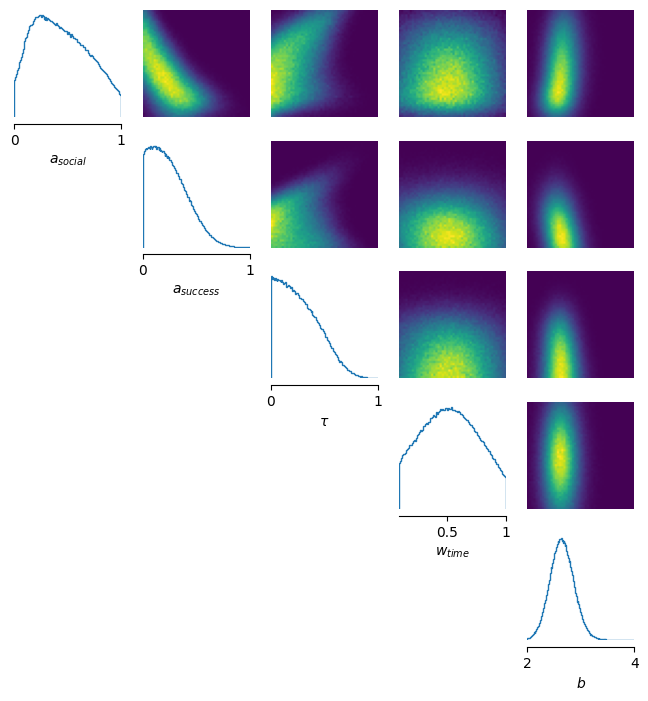

In [20]:
LIMS = [[0, 1], [0, 1], [0, 1.0], [0.1, 1.0], [2.0, 4.0]]  # [0, 1], 

_ = pairplot(
    samples=samples,
    limits=LIMS,
    labels=PARAM_LABS,
    figsize=(8, 8),
)

In [21]:
posterior.set_default_x(x_obs)

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

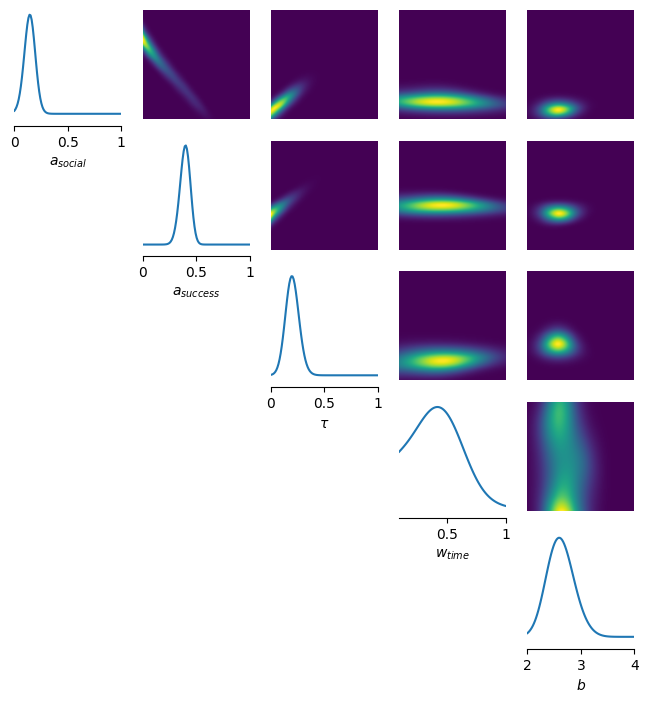

In [22]:
_ = conditional_pairplot(
    density=posterior,
    resolution=100,
    condition=torch.as_tensor([[0.25, 0.5, 0.1, 0.8, 3.5]]),  # , 0.25
    limits=LIMS,
    figsize=(8, 8),
    labels=PARAM_LABS
)